# MLP3

- We will be developing a regression model to predict price of a car.

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import re
import itertools

In [45]:
# Load data
auto_imports = pd.read_csv("./input/processed_data.csv")

# Remove features with poor coverage or lower relevance and keep price target column
columns_to_drop = ['symboling','normalized-losses','wheel-base','height', 'bore','stroke',
'compression-ratio','peak-rpm','city-mpg','highway-mpg','price','make','fuel-type','aspiration',
'num-of-doors','body-style','drive-wheels','engine-location','engine-type','fuel-system','num-of-cylinders']
    
X_auto = np.c_[auto_imports.drop(columns_to_drop, axis=1)]
y_auto = np.c_[auto_imports['price']]

In [46]:
print(X_auto.shape)
print(y_auto.shape)

(201, 5)
(201, 1)


In [47]:
# Scaling features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Split Dataset

In [48]:
# Split dataset to different training and testing sizes
test_sizes_vs_scores = [] # includes test sizes with corresponding best scores and model
ridge_test_sizes_vs_parameters = [] # includes test sizes with the optimal parameters for ridge
knn_test_sizes_vs_parameters = [] # includes test sizes with the optimal parameters for knn

for t_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    X_train, X_test, y_train, y_test = train_test_split(X_auto, y_auto, test_size=t_size, random_state = 0)

    # Linear Regression
    linear_model = LinearRegression().fit(X_train, y_train)
    pred_linear = linear_model.predict(X_test)
    # Format: test size, model, rmse, r2 train, r2 test
    test_sizes_vs_scores.append([t_size, "Linear", np.sqrt(metrics.mean_squared_error(y_test, pred_linear)), linear_model.score(X_train, y_train), linear_model.score(X_test, y_test)])

    # Scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled)

    # Ridge Regression (with optimal alpha regularization parameter)
    min_rmse = 100000
    best_alpha = 0
    r2_train = 0
    r2_test = 0

    for this_alpha in [1, 10, 20, 50, 100, 1000]:
        ridge_model = Ridge(alpha = this_alpha).fit(X_train, y_train)
        pred_ridge = ridge_model.predict(X_test)
        rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, pred_ridge))
        r2_ridge_train = ridge_model.score(X_train, y_train)
        r2_ridge_test = ridge_model.score(X_test, y_test)

        ridge_test_sizes_vs_parameters.append([t_size, this_alpha, r2_ridge_train, r2_ridge_test])

        # From the above list, the best alpha is 1.0
        if this_alpha == 1:
            best_alpha = this_alpha
            min_rmse = rmse_ridge
            r2_train = r2_ridge_train
            r2_test = r2_ridge_test
                 
    test_sizes_vs_scores.append([t_size, "Ridge", min_rmse, r2_train, r2_test])

    
    # KNN Regressor (with optimal k)
    params = {'n_neighbors':list(range(1, 30))}

    knn = neighbors.KNeighborsRegressor()

    model = GridSearchCV(knn, params, cv=5)
    model.fit(X_train, y_train)

    knn_model = neighbors.KNeighborsRegressor(n_neighbors=int(re.search(r'\d+', str(model.best_params_)).group()))

    knn_model.fit(X_train, y_train) 
    pred=knn_model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse

    knn_test_sizes_vs_parameters.append([t_size, model.best_params_])
    test_sizes_vs_scores.append([t_size, "KNN", error, knn_model.score(X_train, y_train), knn_model.score(X_test, y_test)])
    

In [49]:
# Save sample scores to csv
auto_scores_with_diff_test_size = pd.DataFrame(test_sizes_vs_scores, columns=['test_size','type','rmse','r2_train','r2_test'])
auto_scores_with_diff_test_size.to_csv("./results/auto_scores_with_diff_test_sizes.csv", index=False)

In [50]:
# Save optimal parameters with test size for each model in csv
auto_ridge_parameters = pd.DataFrame(ridge_test_sizes_vs_parameters, columns=['test_size', 'alpha', 'r2_train', 'r2_test'])
auto_ridge_parameters .to_csv("./results/auto_ridge_parameters.csv", index=False)

auto_knn_parameters = pd.DataFrame(knn_test_sizes_vs_parameters, columns=['test_size', 'n_neighbors'])
auto_knn_parameters .to_csv("./results/auto_knn_parameters.csv", index=False)

In [51]:
# Find the best training/testing size (when all models has the average lowest rmse)
test_sizes_with_rmse = []
for scores in test_sizes_vs_scores:
    test_sizes_with_rmse.append([scores[0], scores[2]])
    
result = [(k, sum(num for _, num in v)) for k, v in itertools.groupby(test_sizes_with_rmse, lambda x: x[0])]
min = 1000000
size = 0
for r in result:
    if r[1] < min:
        min = r[1]
        size = r[0]
print(size, min)

0.1 10263.755097668502


The best training size is the one with 10% test data.

### K-Cross Validation

In [52]:
# Finding k
X_train, X_test, y_train, y_test = train_test_split(X_auto, y_auto, test_size=0.1, random_state = 0)

for k in [3,5,7,10]: 
    kcfold = KFold(n_splits=k, random_state=None, shuffle=True) 
    kcfold.get_n_splits(X_auto)
    rmse_linear = []
    r2_linear = []
    rmse_ridge = []
    r2_ridge = []
    rmse_knn = []
    r2_knn = []

    linear_model = LinearRegression()
    ridge_model = Ridge(alpha = 1, max_iter=10000)
    knn_model = neighbors.KNeighborsRegressor(n_neighbors=2)
   
    for train_index, test_index in kcfold.split(X_auto):

        X_train, X_test = X_auto[train_index], X_auto[test_index]
        y_train, y_test = y_auto[train_index], y_auto[test_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        linear_model.fit(X_train, y_train)
        ridge_model.fit(X_train_scaled, y_train)
        knn_model.fit(X_train_scaled, y_train)

        y_pred_linear = linear_model.predict(X_test)
        y_pred_ridge = ridge_model.predict(X_test_scaled)
        y_pred_knn = knn_model.predict(X_test_scaled)
        
        rmse_linear.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear)))
        rmse_ridge.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))
        rmse_knn.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)))

        r2_linear.append(metrics.r2_score(y_test, y_pred_linear))
        r2_ridge.append(metrics.r2_score(y_test, y_pred_ridge))
        r2_knn.append(metrics.r2_score(y_test, y_pred_knn))

    print("\n\nScores for", k, "splits:")
    print("Linear Regression")
    print('Average RMSE:', (np.sum(rmse_linear))/kcfold.get_n_splits(X_auto))
    print('Average R2:', (np.sum(r2_linear))/kcfold.get_n_splits(X_auto))
    print("\nRidge Regression")
    print('Average RMSE:', (np.sum(rmse_ridge))/kcfold.get_n_splits(X_auto))
    print('Average R2:', (np.sum(r2_ridge))/kcfold.get_n_splits(X_auto))
    print("\nKNN Regression")
    print('Average RMSE:', (np.sum(rmse_knn))/kcfold.get_n_splits(X_auto))
    print('Average R2:', (np.sum(r2_knn))/kcfold.get_n_splits(X_auto))



Scores for 3 splits:
Linear Regression
Average RMSE: 3532.7019338963432
Average R2: 0.7979584469295715

Ridge Regression
Average RMSE: 3564.497990786183
Average R2: 0.7949902601912586

KNN Regression
Average RMSE: 2685.479740291801
Average R2: 0.8814608882461487


Scores for 5 splits:
Linear Regression
Average RMSE: 3709.907343245478
Average R2: 0.7582853161025731

Ridge Regression
Average RMSE: 3673.17865682837
Average R2: 0.7620717171504302

KNN Regression
Average RMSE: 3245.2143105810633
Average R2: 0.7939040639438503


Scores for 7 splits:
Linear Regression
Average RMSE: 3499.9629052443993
Average R2: 0.7423348124919638

Ridge Regression
Average RMSE: 3512.8287672549786
Average R2: 0.7425966337042935

KNN Regression
Average RMSE: 2836.510227712105
Average R2: 0.8360206472785574


Scores for 10 splits:
Linear Regression
Average RMSE: 3474.773355418668
Average R2: 0.714971115307054

Ridge Regression
Average RMSE: 3496.59361127034
Average R2: 0.721738431544628

KNN Regression
Averag

We will be using 10 splits for k because it is the one with all three models with a lower RMSE.

In [53]:
# Storing scores for 10 splits
linear_model = LinearRegression()
ridge_model = Ridge(alpha = 1, max_iter=10000)
knn_model = neighbors.KNeighborsRegressor(n_neighbors=2)

kcfold = KFold(n_splits=10, random_state=None, shuffle=True) 
rmse_linear = []
r2_train_linear = []
r2_test_linear = []
rmse_ridge = []
r2_train_ridge = []
r2_test_ridge = []
rmse_knn = []
r2_train_knn = []
r2_test_knn = []
   
for train_index, test_index in kcfold.split(X_auto):

    X_train, X_test = X_auto[train_index], X_auto[test_index]
    y_train, y_test = y_auto[train_index], y_auto[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    linear_model.fit(X_train, y_train)
    ridge_model.fit(X_train_scaled, y_train)
    knn_model.fit(X_train_scaled, y_train)

    y_pred_linear = linear_model.predict(X_test)
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    y_pred_knn = knn_model.predict(X_test_scaled)

    # Recording the values of each model
    rmse_linear.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear)))
    r2_train_linear.append(linear_model.score(X_train, y_train))
    r2_test_linear.append(linear_model.score(X_test, y_test))
    rmse_ridge.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))
    r2_train_ridge.append(ridge_model.score(X_train_scaled, y_train))
    r2_test_ridge.append(ridge_model.score(X_test_scaled, y_test))
    rmse_knn.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)))
    r2_train_knn.append(knn_model.score(X_train_scaled, y_train))
    r2_test_knn.append(knn_model.score(X_test_scaled, y_test))

In [54]:
# Saving linear model scores to dataframe
auto_scores_linear = pd.DataFrame()
auto_scores_linear['rmse'] = rmse_linear
auto_scores_linear['r2_train'] = r2_train_linear
auto_scores_linear['r2_test'] = r2_test_linear
print(auto_scores_linear)

          rmse  r2_train   r2_test
0  2142.135258  0.809795  0.892746
1  3452.461581  0.816605  0.813743
2  3067.398173  0.813051  0.846552
3  2955.422404  0.821843  0.684027
4  2903.297034  0.805390  0.891085
5  4648.179264  0.830348  0.681007
6  4135.432015  0.821114  0.740541
7  3921.924966  0.808112  0.848921
8  3964.482839  0.826773  0.680087
9  3728.534712  0.820987  0.759248


In [55]:
# Saving ridge model scores to dataframe
auto_scores_ridge = pd.DataFrame()
auto_scores_ridge['rmse'] = rmse_ridge
auto_scores_ridge['r2_train'] = r2_train_ridge
auto_scores_ridge['r2_test'] = r2_test_ridge
print(auto_scores_ridge)

          rmse  r2_train   r2_test
0  2100.388132  0.802069  0.896886
1  3525.827148  0.808753  0.805743
2  3052.413199  0.805822  0.848047
3  3035.214223  0.815279  0.666735
4  3194.446882  0.798085  0.868145
5  4696.357339  0.822548  0.674360
6  3335.922602  0.810271  0.831166
7  4352.668016  0.800885  0.813913
8  4131.740245  0.819436  0.652524
9  3614.774600  0.813241  0.773715


In [56]:
# Saving knn model scores to dataframe
auto_scores_knn = pd.DataFrame()
auto_scores_knn['rmse'] = rmse_knn
auto_scores_knn['r2_train'] = r2_train_knn
auto_scores_knn['r2_test'] = r2_test_knn
print(auto_scores_knn)

          rmse  r2_train   r2_test
0  1893.109284  0.971323  0.916234
1  1709.079950  0.970499  0.954356
2  1878.291398  0.973293  0.942463
3  2870.883616  0.975880  0.701845
4  2531.220464  0.971083  0.917212
5  7132.274826  0.973884  0.248946
6  3456.487802  0.974399  0.818742
7  2155.849099  0.969157  0.954350
8  1847.808790  0.973265  0.930502
9  2333.975787  0.970770  0.905662


In [57]:
# Saved to csv files
auto_scores_linear.to_csv("./results/auto_scores_linear.csv", index=False)
auto_scores_ridge.to_csv("./results/auto_scores_ridge.csv", index=False)
auto_scores_knn.to_csv("./results/auto_scores_knn.csv", index=False)

### Plotting Scores (RMSE)

In [58]:
# Setting up models
X_auto_scaled = scaler.fit_transform(X_auto)

linear_model = LinearRegression()
ridge_model = Ridge(alpha = 1, max_iter=10000)
knn_model = neighbors.KNeighborsRegressor(n_neighbors=2)

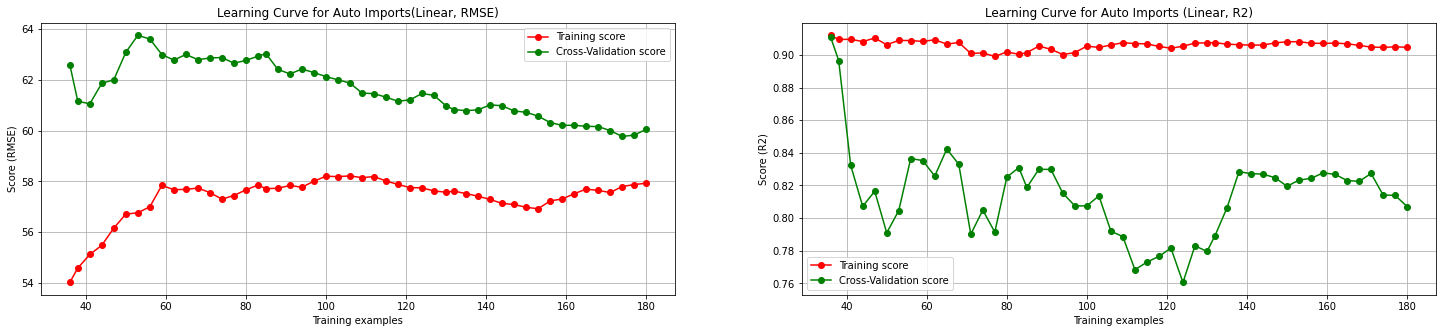

In [59]:
# Learning Curve for Linear RMSE
train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(linear_model, X_auto, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ((rmse), (r2)) = plt.subplots(1, 2, figsize=(25, 5))
    
rmse.set_title('Learning Curve for Auto Imports(Linear, RMSE)')
rmse.set_xlabel("Training examples")
rmse.set_ylabel("Score (RMSE)")
rmse.grid()

rmse.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
rmse.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
rmse.legend(loc="best")

train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(linear_model, X_auto, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='r2', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
    
r2.set_title('Learning Curve for Auto Imports (Linear, R2)')
r2.set_xlabel("Training examples")
r2.set_ylabel("Score (R2)")
r2.grid()

r2.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
r2.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
r2.legend(loc="best")

plt.show()

The optimal training size will be around 120 to 140 for linear regression. This is a case of high bias.

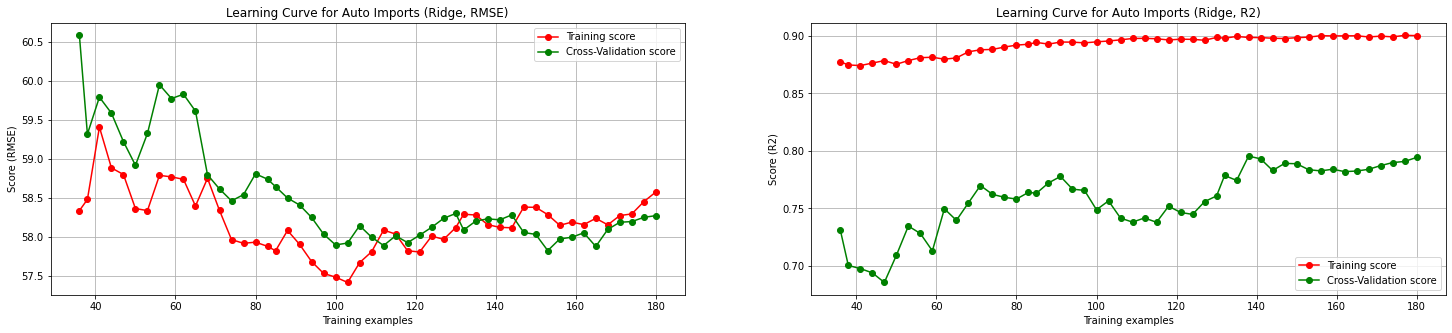

In [60]:
# Learning Curve for Ridge RMSE
train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(ridge_model, X_auto_scaled, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ((rmse, r2)) = plt.subplots(1, 2, figsize=(25, 5))
    
rmse.set_title('Learning Curve for Auto Imports (Ridge, RMSE)')
rmse.set_xlabel("Training examples")
rmse.set_ylabel("Score (RMSE)")
rmse.grid()

rmse.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
rmse.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
rmse.legend(loc="best")

train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(ridge_model, X_auto_scaled, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='r2', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
    
r2.set_title('Learning Curve for Auto Imports (Ridge, R2)')
r2.set_xlabel("Training examples")
r2.set_ylabel("Score (R2)")
r2.grid()

r2.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
r2.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
r2.legend(loc="best")

plt.show()

Looking from the curve, training sizes around 140 to 180 gives the optimal results

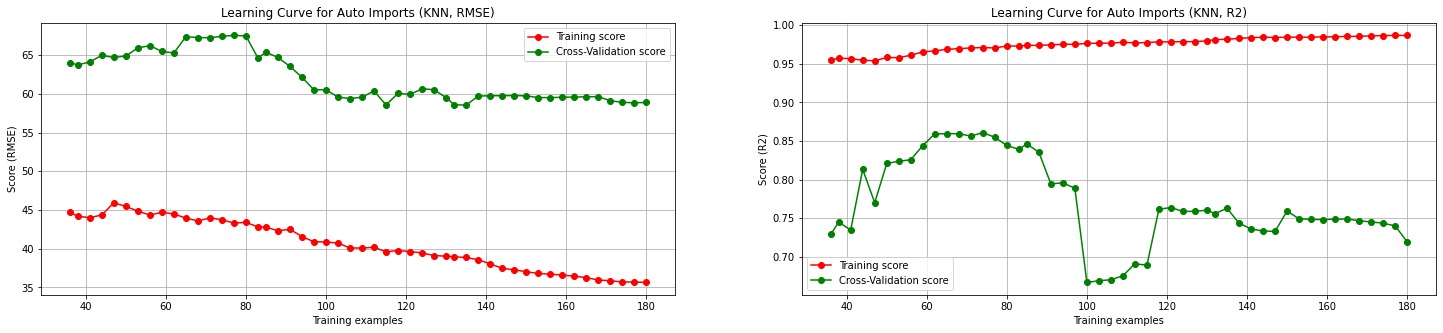

In [61]:
# Learning curve for KNN 
train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(knn_model, X_auto_scaled, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve RMSE
fig, ((rmse, r2)) = plt.subplots(1, 2, figsize=(25, 5))
    
rmse.set_title('Learning Curve for Auto Imports (KNN, RMSE)')
rmse.set_xlabel("Training examples")
rmse.set_ylabel("Score (RMSE)")
rmse.grid()

rmse.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
rmse.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
rmse.legend(loc="best")

train_sizes = np.linspace(0.2, 1, 50)

train_sizes, train_mse, test_mse = learning_curve(knn_model, X_auto_scaled, y_auto, 
                                    train_sizes = train_sizes, 
                                    scoring='r2', 
                                    cv=10, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
    
r2.set_title('Learning Curve for Auto Imports (KNN, R2)')
r2.set_xlabel("Training examples")
r2.set_ylabel("Score (R2)")
r2.grid()

r2.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
r2.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation score")
r2.legend(loc="best")

plt.show()

Both scores are far apart from each other, that means this is a case of high variance (overfitting).

In [62]:
df_score_linear = pd.read_csv("./results/auto_scores_linear.csv")
df_score_ridge = pd.read_csv("./results/auto_scores_ridge.csv")
df_score_knn = pd.read_csv("./results/auto_scores_knn.csv")
df_scores_diff_test_size = pd.read_csv("./results/auto_scores_with_diff_test_sizes.csv")

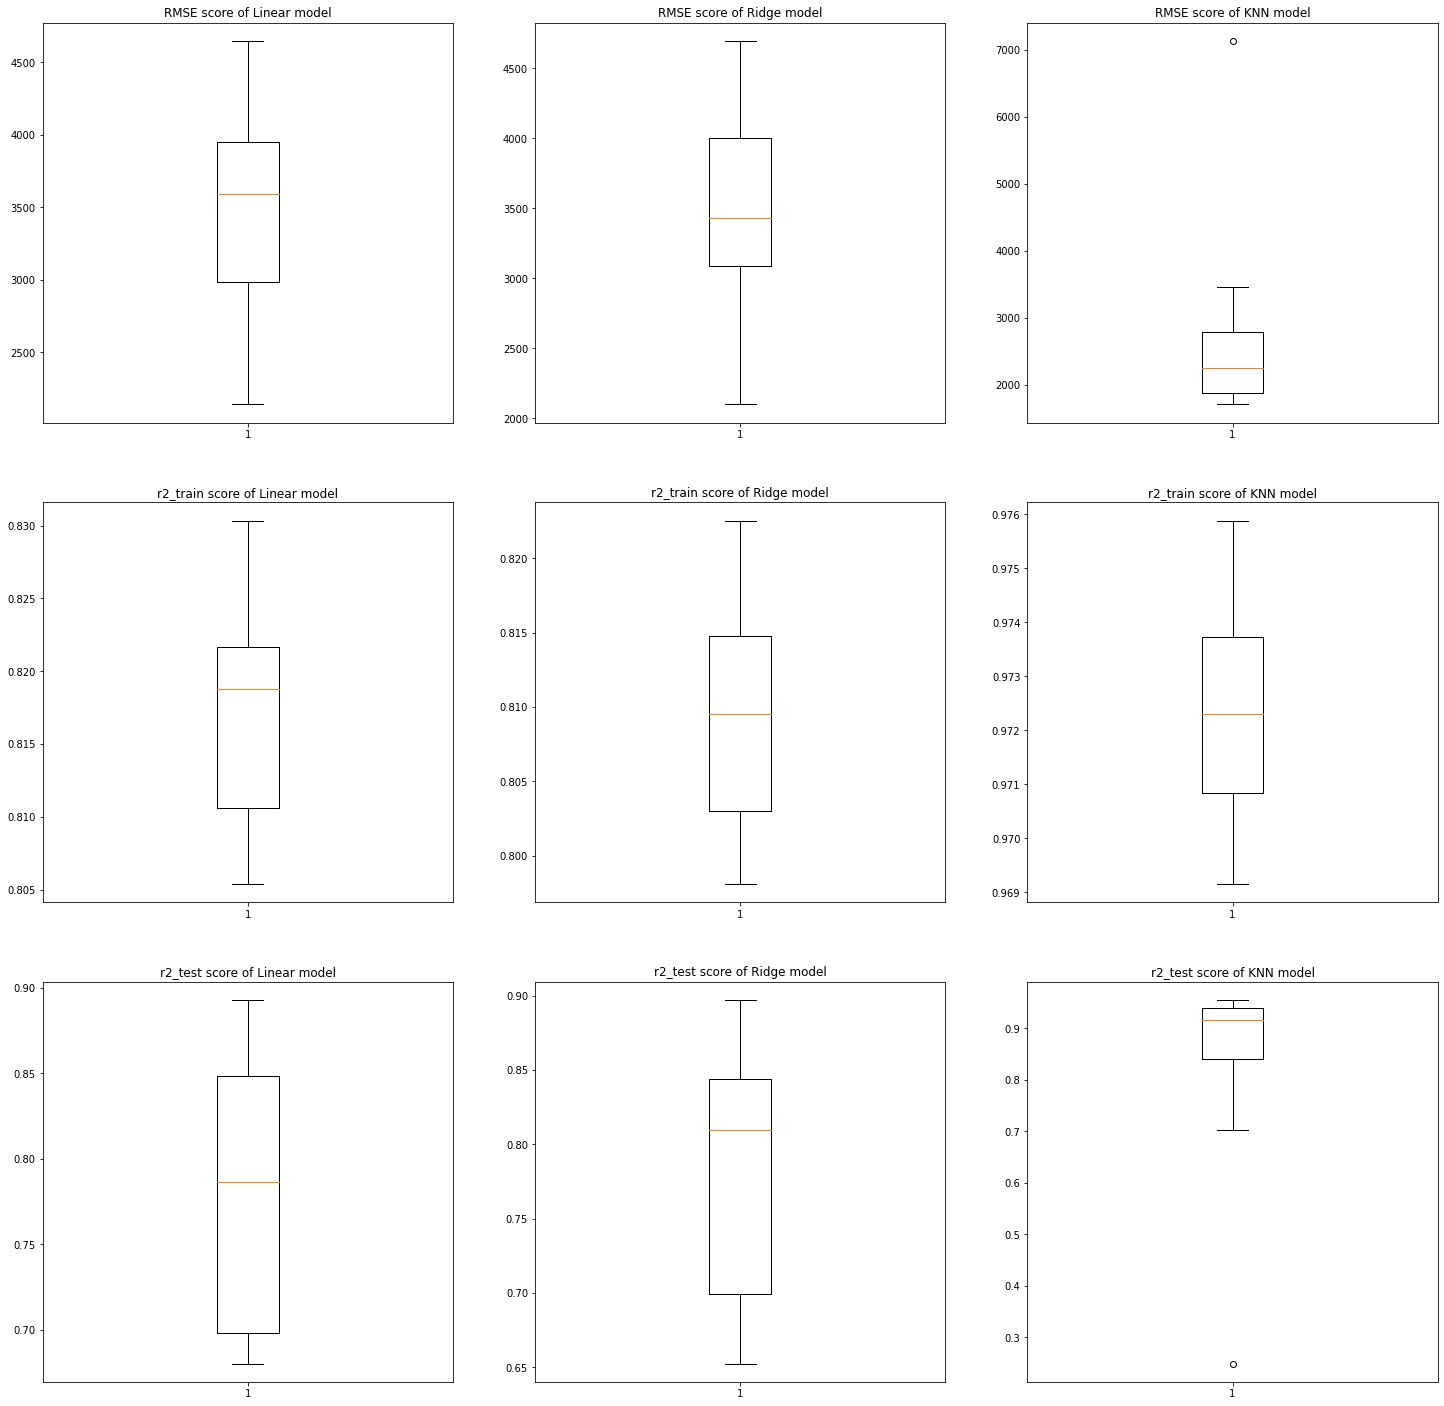

In [63]:
fig, axs = plt.subplots(3, 3, figsize=(25,25))
axs[0][0].boxplot(df_score_linear['rmse'])
axs[0][1].boxplot(df_score_ridge['rmse'])
axs[0][2].boxplot(df_score_knn['rmse'])
axs[0][0].set_title("RMSE score of Linear model")
axs[0][1].set_title("RMSE score of Ridge model")
axs[0][2].set_title("RMSE score of KNN model")

axs[1][0].boxplot(df_score_linear['r2_train'])
axs[1][1].boxplot(df_score_ridge['r2_train'])
axs[1][2].boxplot(df_score_knn['r2_train'])
axs[1][0].set_title("r2_train score of Linear model")
axs[1][1].set_title("r2_train score of Ridge model")
axs[1][2].set_title("r2_train score of KNN model")

axs[2][0].boxplot(df_score_linear['r2_test'])
axs[2][1].boxplot(df_score_ridge['r2_test'])
axs[2][2].boxplot(df_score_knn['r2_test'])
axs[2][0].set_title("r2_test score of Linear model")
axs[2][1].set_title("r2_test score of Ridge model")
axs[2][2].set_title("r2_test score of KNN model")

plt.show()

In [64]:
linear_test_size = df_scores_diff_test_size[df_scores_diff_test_size.type == 'Linear']
ridge_test_size = df_scores_diff_test_size[df_scores_diff_test_size.type == 'Ridge']
knn_test_size = df_scores_diff_test_size[df_scores_diff_test_size.type == 'KNN']
df_scores_diff_test_size

,test_size,type,rmse,r2_train,r2_test
0,0.10,Linear,4029.940441,0.828477,0.666339
1,0.10,Ridge,4225.349085,0.821595,0.633196
2,0.10,KNN,2008.465572,0.997174,0.917122
3,0.15,Linear,4340.772121,0.813082,0.794809
4,0.15,Ridge,4679.208220,0.805180,0.761565
5,0.15,KNN,2473.559835,0.997963,0.933370
6,0.20,Linear,4107.359870,0.817047,0.777348
7,0.20,Ridge,4354.828213,0.808622,0.749710
8,0.20,KNN,3423.834511,0.960532,0.845287
9,0.25,Linear,4153.458329,0.798113,0.805802


In [65]:
print(linear_test_size, "\n")
print(ridge_test_size, "\n")
print(knn_test_size, "\n")

    test_size    type         rmse  r2_train   r2_test
0        0.10  Linear  4029.940441  0.828477  0.666339
3        0.15  Linear  4340.772121  0.813082  0.794809
6        0.20  Linear  4107.359870  0.817047  0.777348
9        0.25  Linear  4153.458329  0.798113  0.805802
12       0.30  Linear  4550.939288  0.809364  0.758312
15       0.35  Linear  4315.734368  0.813726  0.764123
18       0.40  Linear  4241.935504  0.813232  0.761494
21       0.45  Linear  4013.832363  0.794131  0.784399
24       0.50  Linear  3890.287174  0.801713  0.783478
27       0.55  Linear  3911.645614  0.784231  0.781972
30       0.60  Linear  4485.075188  0.810652  0.729473
33       0.65  Linear  4306.433258  0.828318  0.736335
36       0.70  Linear  4327.758654  0.818281  0.734566
39       0.75  Linear  4527.314702  0.832827  0.701856 

    test_size   type         rmse  r2_train   r2_test
1        0.10  Ridge  4225.349085  0.821595  0.633196
4        0.15  Ridge  4679.208220  0.805180  0.761565
7        0.

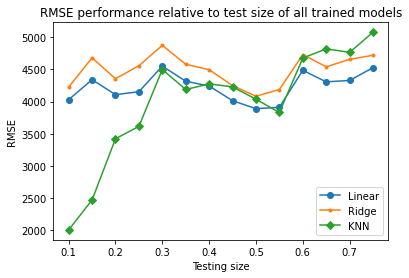

In [66]:
plt.plot(linear_test_size['test_size'], linear_test_size['rmse'], label = "Linear", marker="o")
plt.plot(ridge_test_size['test_size'], ridge_test_size['rmse'], label = "Ridge", marker=".")
plt.plot(knn_test_size['test_size'], knn_test_size['rmse'], label = "KNN", marker="D")
plt.title("RMSE performance relative to test size of all trained models")
plt.xlabel("Testing size")
plt.ylabel("RMSE")
plt.legend()